In [112]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


['KernelLanguages.csv', 'UserFollowers.csv', 'Datasets.csv', 'Tags.csv', 'Kernels.csv', 'DatasourceObjects.csv', 'Forums.csv', 'TeamMemberships.csv', 'KernelVersionDatasetSources.csv', 'Datasources.csv', 'DatasourceVersionObjectTables.csv', 'UserAchievements.csv', 'ForumMessageVotes.csv', 'Users.csv', 'DatasetTags.csv', 'KernelVersions.csv', 'KernelVersionKernelSources.csv', 'DatasetVersions.csv', 'UserOrganizations.csv', 'ForumMessages.csv', 'DatasetVotes.csv', 'Organizations.csv', 'Teams.csv', 'ForumTopics.csv', 'KernelVersionOutputFiles.csv', 'KernelTags.csv', 'Competitions.csv', 'KernelVersionCompetitionSources.csv', 'KernelVotes.csv', 'CompetitionTags.csv', 'Submissions.csv']


* based on: 
https://www.kaggle.com/pavlofesenko/strategies-to-earn-discussion-medals

In [113]:
forums = pd.read_csv('../input/Forums.csv').set_index("Id").rename(columns={"Title":"Forum_Title"})
forums.head()

,ParentForumId,Forum_Title
Id,,
1,8.0,Predict HIV Progression
2,8.0,Forecast Eurovision Voting
3,8.0,World Cup 2010 - Take on the Quants
4,8.0,INFORMS Data Mining Contest 2010
5,NaN,Active Competitions


In [114]:
## basic users info (name..). Note that this is leaky(PerformanceTier)! it's not time stamped. It can also be joined with more data, e.g. teams, organization
users = pd.read_csv('../input/Users.csv').set_index("Id").drop("PerformanceTier",axis=1).drop_duplicates()
print(users.shape)
users.head()

(3011044, 3)


,UserName,DisplayName,RegisterDate
Id,,,
1,kaggleteam,Kaggle Team,03/24/2011
368,antgoldbloom,Anthony Goldbloom,01/20/2010
381,iguyon,Isabelle,01/29/2010
385,demonjosh,Demon Josh,02/02/2010
387,nicholasgruen,Nicholas Gruen,02/02/2010


In [115]:
### there are multiple ForumId s . Not unique! 
## Many of these column are effectively leaky variables (not time stamped, and they could indicate a "topic" containing a popular post)

forumsTopics = pd.read_csv('../input/ForumTopics.csv').drop(['Score'],axis=1).drop_duplicates().set_index("Id")
print(forumsTopics.shape)
print(forumsTopics.nunique())
forumsTopics.head()

(72726, 11)
ForumId                 2771
KernelId               22491
LastForumMessageId     72726
FirstForumMessageId    72722
CreationDate           72542
LastCommentDate        72681
Title                  67196
IsSticky                   2
TotalViews              5639
TotalMessages            236
TotalReplies             231
dtype: int64


,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,TotalMessages,TotalReplies
Id,,,,,,,,,,,
1,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,19,18
2,1,NaN,4,2.0,04/29/2010 15:48:46,04/29/2010 15:48:46,Question regarding algorithms used,False,2185,3,2
3,1,NaN,41,5.0,04/30/2010 14:32:29,04/30/2010 14:32:29,Question about data,False,2121,3,2
4,1,NaN,13,6.0,04/30/2010 15:40:57,04/30/2010 15:40:57,Biased sets,False,2780,4,3
5,1,NaN,12,10.0,05/01/2010 11:00:57,05/01/2010 11:00:57,Non-standard nucleotide codings,False,2045,2,1


In [116]:
forumsTopics.columns

Index(['ForumId', 'KernelId', 'LastForumMessageId', 'FirstForumMessageId',
       'CreationDate', 'LastCommentDate', 'Title', 'IsSticky', 'TotalViews',
       'TotalMessages', 'TotalReplies'],
      dtype='object')

* optional: clean html from messages, +- extract code into seperate col

In [117]:
messages = pd.read_csv('../input/ForumMessages.csv').drop("MedalAwardDate",axis=1)
messages = messages[messages.Message.notna()].drop_duplicates(subset="Message")
messages.Medal.fillna(-1,inplace=True)
messages['PostDate'] = pd.to_datetime(messages['PostDate'], infer_datetime_format=True)
# messages = messages.sort_values('PostDate')
messages.tail()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal
458762,530174,91973,2962386,2019-05-12 02:11:00,530006.0,<p>Yep. It works. Unnecessarily edited it out....,-1.0
458763,530233,87229,1187145,2019-05-12 07:50:18,NaN,"<p><a href=""https://www.kaggle.com/wordroid/so...",-1.0
458764,530235,92024,1215264,2019-05-12 08:10:01,NaN,<p>If my model has MAE error 0.25 before scali...,-1.0
458765,530243,92027,2415058,2019-05-12 08:58:29,NaN,<p>My Medium article with this kernel - <a hr...,-1.0
458766,530261,83336,2598701,2019-05-12 09:57:06,NaN,"<p>Well, I just lost all the work I did yester...",-1.0


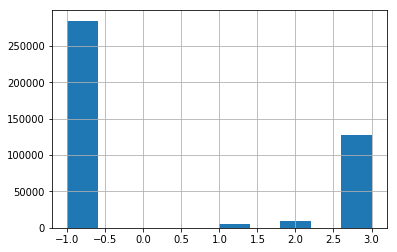

In [118]:
messages["Medal"].hist()

In [119]:
print(messages["Medal"].isna().sum())
messages["Medal"].describe()

0


count    427780.000000
mean          0.288249
std           1.837954
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           3.000000
max           3.000000
Name: Medal, dtype: float64

In [120]:
print(messages.shape)
# messages= messages.join(forumsTopics,on="ForumTopicId",how="left")
messages = messages.join(forumsTopics,on="ForumTopicId",how="inner")
print(messages.shape)
# print(messages.join(forumsTopics,on="ForumTopicId",how="inner").shape)
# messages.tail()

(427780, 7)
(424627, 18)


In [121]:
messages.tail()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,TotalMessages,TotalReplies
458714,530205,92018,1709280,2019-05-12 05:02:04,NaN,"<p>If you find this kernel useful, look at - <...",-1.0,16860,3869736.0,530205,530205.0,05/12/2019 04:18:27,05/12/2019 05:02:04,"NLP Build Embedding Matrix, without full pre-load",False,0,1,0
458737,530238,92025,1435099,2019-05-12 08:27:45,NaN,<p>How to upload a file with a link which ends...,-1.0,2239,NaN,530238,530238.0,05/12/2019 08:27:45,05/12/2019 08:27:45,Upload new dataset,False,0,1,0
458754,530270,92035,3082326,2019-05-12 10:35:16,NaN,<p>This is a work in progress</p>,-1.0,16860,3871538.0,530270,530270.0,05/12/2019 10:05:38,05/12/2019 10:35:16,kerneleae97f16ab,False,0,1,0
458755,530273,92036,2537882,2019-05-12 10:44:21,NaN,<p>준비하시느라 고생 많으셨습니다~~~</p>,-1.0,16860,3799614.0,530273,530273.0,05/05/2019 12:43:52,05/12/2019 10:44:21,Boston_Housing,False,0,1,0
458765,530243,92027,2415058,2019-05-12 08:58:29,NaN,<p>My Medium article with this kernel - <a hr...,-1.0,16860,3632883.0,530243,530243.0,04/19/2019 07:16:47,05/12/2019 08:58:29,CNN for handwritten alphabets,False,0,1,0


In [122]:
forums.head()

,ParentForumId,Forum_Title
Id,,
1,8.0,Predict HIV Progression
2,8.0,Forecast Eurovision Voting
3,8.0,World Cup 2010 - Take on the Quants
4,8.0,INFORMS Data Mining Contest 2010
5,NaN,Active Competitions


In [123]:
messages = messages.join(forums,on="ForumId")


In [124]:
## add parent forum title, if any
messages = messages.join(forums,on="ParentForumId",rsuffix="_parent")
print(messages.shape)

(424627, 22)


In [125]:
messages = messages.join(users,on="PostUserId")

In [126]:
messages.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,TotalMessages,TotalReplies,ParentForumId,Forum_Title,ParentForumId_parent,Forum_Title_parent,UserName,DisplayName,RegisterDate
0,1,1,478,2010-04-28 23:13:08,NaN,<div>In response to a comment on the No Free H...,-1.0,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,19,18,8.0,Predict HIV Progression,NaN,Past Competitions,judowill,Will Dampier,04/14/2010
508,76,1,808,2010-04-28 23:13:08,NaN,Use a mixture of different models (linear regr...,-1.0,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,19,18,8.0,Predict HIV Progression,NaN,Past Competitions,alexxanderlarko,Alexander Larko,05/14/2010
811,116,1,1486,2010-04-28 23:13:08,NaN,My first thoughts on this problem are that it ...,-1.0,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,19,18,8.0,Predict HIV Progression,NaN,Past Competitions,colingreen,Colin Green,06/27/2010
812,119,1,703,2010-04-28 23:13:08,NaN,The theory of deep belief networks is probably...,-1.0,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,19,18,8.0,Predict HIV Progression,NaN,Past Competitions,rajstennajbarrabas,Rajstennaj Barrabas,05/05/2010
911,130,1,1486,2010-04-28 23:13:08,NaN,"Going by Hinton's last two google techtalks, r...",-1.0,1,NaN,212,1.0,04/28/2010 23:13:08,04/28/2010 23:13:08,A few techniques you might try:,False,9405,19,18,8.0,Predict HIV Progression,NaN,Past Competitions,colingreen,Colin Green,06/27/2010


#### text length filter
* Very long texts are expensive to compute on
* We see that while post lengths differ between the classes (as expected), the outliers remain the same, so it seems safe to exclude some of the excessively long posts

In [127]:
messages["message_word_length"] = messages["Message"].str.split().str.len()
messages["message_char_length"] = messages["Message"].str.len()

In [128]:
print(messages.loc[messages.Medal > -1]["message_word_length"].quantile(0.995))
messages.loc[messages.Medal > -1]["message_word_length"].describe()

651.1549999999988


count    141770.000000
mean         64.569549
std         108.006569
min           1.000000
25%          15.000000
50%          34.000000
75%          75.000000
max        7317.000000
Name: message_word_length, dtype: float64

In [129]:
print(messages["message_word_length"].quantile(0.995))
messages["message_word_length"].describe()

460.0


count    424627.000000
mean         50.455459
std          87.444557
min           1.000000
25%          12.000000
50%          28.000000
75%          59.000000
max       18934.000000
Name: message_word_length, dtype: float64

In [130]:
messages["message_char_length"].describe()

count    424627.000000
mean        347.257699
std         781.562663
min           1.000000
25%          83.000000
50%         188.000000
75%         395.000000
max      240829.000000
Name: message_char_length, dtype: float64

In [131]:
messages = messages.loc[messages["message_word_length"]<900]
print(messages.shape[0])

424181


In [132]:
messages["message_word_length"].describe()

count    424181.000000
mean         48.981487
std          66.302885
min           1.000000
25%          12.000000
50%          28.000000
75%          59.000000
max         899.000000
Name: message_word_length, dtype: float64

In [133]:
messages.columns

Index(['Id', 'ForumTopicId', 'PostUserId', 'PostDate', 'ReplyToForumMessageId',
       'Message', 'Medal', 'ForumId', 'KernelId', 'LastForumMessageId',
       'FirstForumMessageId', 'CreationDate', 'LastCommentDate', 'Title',
       'IsSticky', 'TotalViews', 'TotalMessages', 'TotalReplies',
       'ParentForumId', 'Forum_Title', 'ParentForumId_parent',
       'Forum_Title_parent', 'UserName', 'DisplayName', 'RegisterDate',
       'message_word_length', 'message_char_length'],
      dtype='object')

In [135]:
messages["Medal"] = (messages["Medal"]>-1).astype(int)

In [137]:
# messages["First_or_last_message"] = ((messages['Id']==messages['LastForumMessageId']) | messages['Id']==messages['FirstForumMessageId'])

# messages["First_or_last_message"].describe()  ### only 20 such cases - maybe wrong key? Ignore for now

count     424181
unique         2
top        False
freq      424162
Name: First_or_last_message, dtype: object

In [136]:
messages.tail()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,TotalMessages,TotalReplies,ParentForumId,Forum_Title,ParentForumId_parent,Forum_Title_parent,UserName,DisplayName,RegisterDate,message_word_length,message_char_length
458714,530205,92018,1709280,2019-05-12 05:02:04,NaN,"<p>If you find this kernel useful, look at - <...",False,16860,3869736.0,530205,530205.0,05/12/2019 04:18:27,05/12/2019 05:02:04,"NLP Build Embedding Matrix, without full pre-load",False,0,1,0,NaN,Kernels,NaN,NaN,firstanton,Anton Kochubey,03/10/2018,11,220
458737,530238,92025,1435099,2019-05-12 08:27:45,NaN,<p>How to upload a file with a link which ends...,False,2239,NaN,530238,530238.0,05/12/2019 08:27:45,05/12/2019 08:27:45,Upload new dataset,False,0,1,0,9.0,Questions & Answers,NaN,General,qgh1223,qiuguhao,11/21/2017,21,101
458754,530270,92035,3082326,2019-05-12 10:35:16,NaN,<p>This is a work in progress</p>,False,16860,3871538.0,530270,530270.0,05/12/2019 10:05:38,05/12/2019 10:35:16,kerneleae97f16ab,False,0,1,0,NaN,Kernels,NaN,NaN,nithingowrav,Nithin,04/13/2019,6,33
458755,530273,92036,2537882,2019-05-12 10:44:21,NaN,<p>준비하시느라 고생 많으셨습니다~~~</p>,False,16860,3799614.0,530273,530273.0,05/05/2019 12:43:52,05/12/2019 10:44:21,Boston_Housing,False,0,1,0,NaN,Kernels,NaN,NaN,vh1981,vh1981,11/25/2018,3,26
458765,530243,92027,2415058,2019-05-12 08:58:29,NaN,<p>My Medium article with this kernel - <a hr...,False,16860,3632883.0,530243,530243.0,04/19/2019 07:16:47,05/12/2019 08:58:29,CNN for handwritten alphabets,False,0,1,0,NaN,Kernels,NaN,NaN,yairhadad1,Yair Hadad,10/27/2018,10,219


In [ ]:
messages.drop(['Id', 'ForumId','LastForumMessageId',
       'FirstForumMessageId', 'ForumTopicId','ParentForumId', 'ParentForumId_parent',
               'TotalReplies'],axis=1).drop_duplicates().to_csv("kaggle_medals_train_v1.csv.gz",index=False,compression="gzip")